Example notebook for running meK-Means on a 10x PBMC dataset

In [47]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

import anndata
import scanpy as sc

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph

import igraph as ig
import leidenalg as la


In [48]:
#Set path to monod package
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [49]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [50]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Import PBMC data**

In [52]:
#List cell type annotations (from previous annotations) to keep cells from, in analysis
tokeep = ['Tcells','Monocytes','Bcells']
chosen = [tokeep] 

In [53]:
#Set number of ks to fit in mixture model
num_ks = 2
ks = [3,5] 

In [54]:
#Set looms files for each inference run (i.e. each choice of k)

dataset_meta = ['pbmc_10k_v3']

subcluster_names = []
for r in range(len(chosen)):
    subcluster_names += [chosen[r]]*num_ks

sub_names_only = ['_'.join(n) for n in subcluster_names]

for i in range(len(ks)):
    sub_names_only[i] = sub_names_only[i]+'_k'+str(ks[i])
    
cluster_names = []

dataset_names = [x+'_'+y for x in dataset_meta for y in sub_names_only]  
raw_data_locations = [x for x in dataset_meta for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

#Feature names in loom file
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/10x_pbmcs/loom/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)

In [55]:
dataset_names

['pbmc_10k_v3_Tcells_Monocytes_Bcells_k3',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k5']

Select genes to do inference for, based on minimum U/S count criteria and literature genes

In [56]:
#From Cell Atlas - cite Angel/Sina
all_marks = pd.read_csv('/home/tchari/metadata/all_pbmc_markers.csv') 
print(all_marks.head())

#From lit + https://satijalab.org/seurat/articles/pbmc3k_tutorial.html
toplot_marks = ['CD300E','FCGR2B','CD40',
                'CD69','MS4A1','CD79A','PTPRC',
                'CD3D','IL7R','LEF1','TRAC','CD4','CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
      'CD93','CSTA','FPR1','CD14','CD36',
      'CD79A','CD22','BLK','IGHD','VPREB3','CD28','IRF4','CCR6','GATA3','IL2RA','FOXP1','CD38',
               'CX3CR1','CD86','ADGRE1'] + ['CD14','FCGR3A','FCGR3B','CCR2','CCR5','CCR7',
'CD69','ITGAE','CTLA4','NCAM1','FOXP3','STAT4', 'TCF7','IL26',
'IL22','IL13','KLRB1','CXCR3','CD38',
'CLEC9A','ITGAX','XCR1','CD1C','CD207','ITGAM', 'NOTCH2',
'BATF3','CCR7','CD8A','CD8B',
'BCL2','BCL6','CD5','CD27','CD79B','SDC1','TLR9','XBP1','GZMB','IL3RA','CD74',
'IL7R', 'CCR7','LYZ','S100A4','GNLY', 'NKG7','FCER1A', 'CST3','PPBP','PF4'] 

markers = list(all_marks['gene_name']) + toplot_marks #Added

markers = list(np.unique(markers)) #Added

print(len(markers))

  gene_name  num_cell_types
0     PTPRC              28
1      CD14              27
2     IL-7R              24
3      CD3D              24
4    FCG3RA              23
2357


In [57]:
annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header=None)
print(annots.head())

filt_markers = [m for m in markers if m in list(annots[0])] #Filter for genes in transcriptome annotation
len(filt_markers)

       0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]


2011

In [58]:
#Remove genes with duplicate names
dups = ['FCGR2C','GGTA1P', 'ANKRD36BP1', 'HSPA7','HLA-DRB4','HLA-DRB3','HLA-DPB2','GVINP1',
'ANXA2P2','DENND10P1','CES1P1','CORO7-PAM16','CRYM-AS1','WHAMMP3','SUZ12P1','STING1', 
'STAG3L1','STAG3L3','STAG3L4', 'TM4SF19-TCTEX1D2','KDM5D','LCT-AS1','KIR2DS2','KIR2DS5',
'KIR3DS1','PMS2P5','PALM2AKAP2','NCF1B','NCF1C']
filt_markers = [i for i in filt_markers if i not in dups]
len(filt_markers)

1982

In [59]:
#Filter genes again for acceptable U/S bounds (gene needs to have minimum counts of each)
#Read in loom + layers
ds = lp.connect('/home/tchari/counts/10x_pbmcs/loom/pbmc_10k_v3.loom')
s = ds.layers['spliced'][:,:]
u = ds.layers['unspliced'][:,:]
g_names = ds.ra['gene_name']

#Default Monod filtering params
filt_param={
        "min_U_mean": 0.01,
        "min_S_mean": 0.01,
        "max_U_max": 400,
        "max_S_max": 400,
        "min_U_max": 3,
        "min_S_max": 3,
    }

expr_filt = monod.preprocess.threshold_by_expression(s,u,filt_param)
ds.close()

INFO:root:5887 genes retained after expression filter.


In [60]:
fin_markers = set(filt_markers).intersection(list(g_names[expr_filt]))
len(fin_markers)

1082

In [61]:
fin_markers = list(fin_markers) #Final list of potential genes to fit

## **Filter Cells/Barcodes**
Remove low (UMI) count cells

In [62]:
cluster_annotations = []
for k in range(len(dataset_meta)):
    cluster_assignments = pd.read_csv(f'/home/tchari/metadata/{dataset_meta[k]}_analysis/analysis/clustering/kmeans_4_clusters/clusters.csv')
    print(cluster_assignments['Barcode'].str[-1:].unique())
    cluster_assignments['Barcode'] = cluster_assignments['Barcode'].str[:-2]
    cluster_annotations.append(cluster_assignments)

['1']


In [63]:
clus_names = dict(zip([1,2,3,4],['Tcells','Monocytes','Bcells','Other']))
clus_names

{1: 'Tcells', 2: 'Monocytes', 3: 'Bcells', 4: 'Other'}

In [64]:
cluster_annotations[0]['Cluster_name'] = [clus_names[i] for i in cluster_annotations[0]['Cluster']]
cluster_annotations[0].head()

,Barcode,Cluster,Cluster_name
0,AAACCCAAGCGCCCAT,1,Tcells
1,AAACCCAAGGTTCCGC,2,Monocytes
2,AAACCCACAGAGTTGG,2,Monocytes
3,AAACCCACAGGTATGG,1,Tcells
4,AAACCCACATAGTCAC,3,Bcells


Dataset pbmc_10k_v3. 
	11756 barcodes in loom, 11171 pass filter. 11769 in annotations; of these, 11536 in loom and 11121 in filtered loom.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.


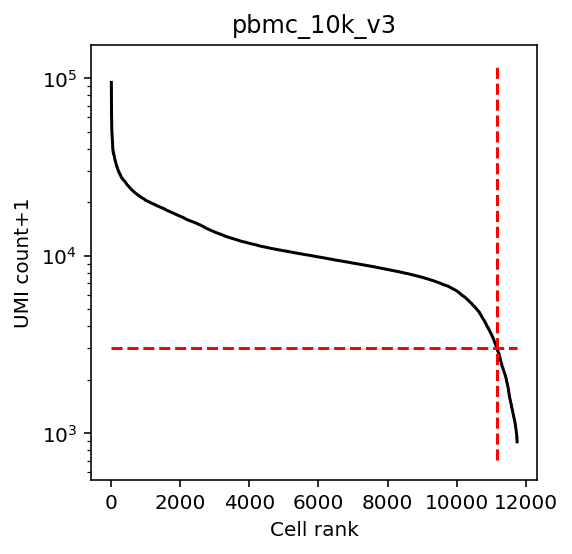

In [65]:
#Filter cell barcodes by counts
cf = []
thr_lb = [3e3]
fig1,ax1 = plt.subplots(1,1,figsize=(4,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k ]
    dataset_name = raw_data_locations[len(subcluster_names)*k ]
    
    clusters = cluster_annotations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(clusters)
        annot_bcs_in_loom = clusters['Barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = clusters['Barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        for j,cluster in enumerate(subcluster_names):
            annot_bcs = clusters[clusters['Cluster_name'].isin(cluster)]['Barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')

    ax1.set_title(dataset_name)

In [66]:
#Save 'original' cell type assignments for filtered barcodes/cells
all_assigns = [list(clusters['Cluster_name'][clusters['Barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns)) 

10913


## **Set up Data and Selected  Genes for Inference**

In [67]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k3
INFO:root:10913 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5814 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k5
INFO:root:10913 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5814 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5 created.
INFO:root:Total of 1000 genes selected.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/diagnostic_figures already exists.


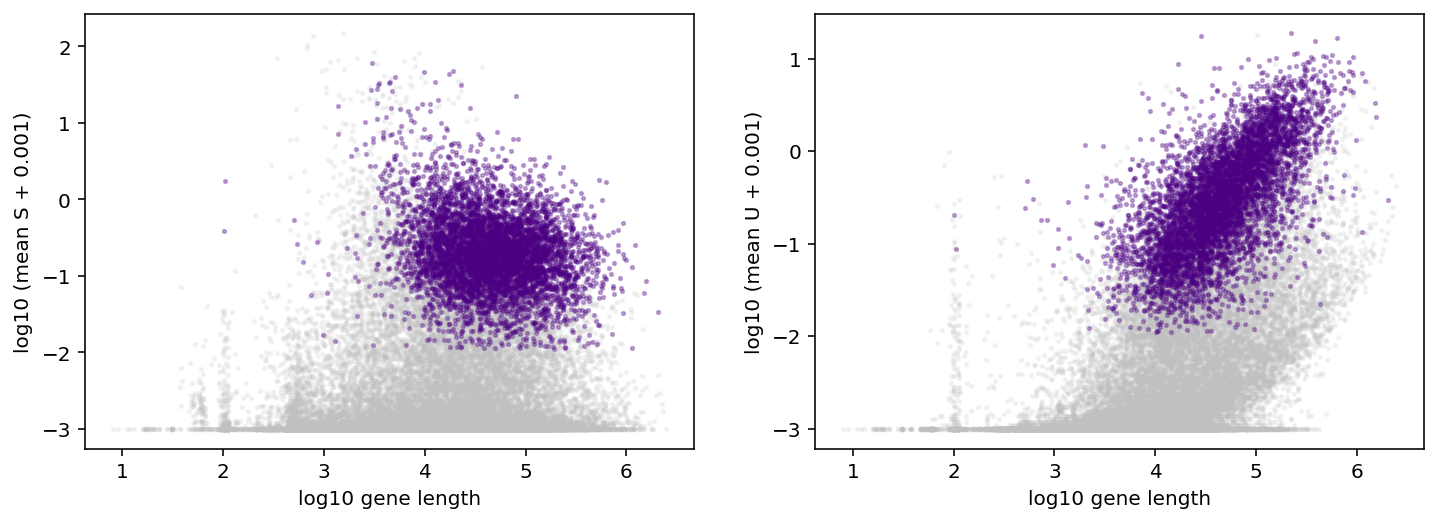

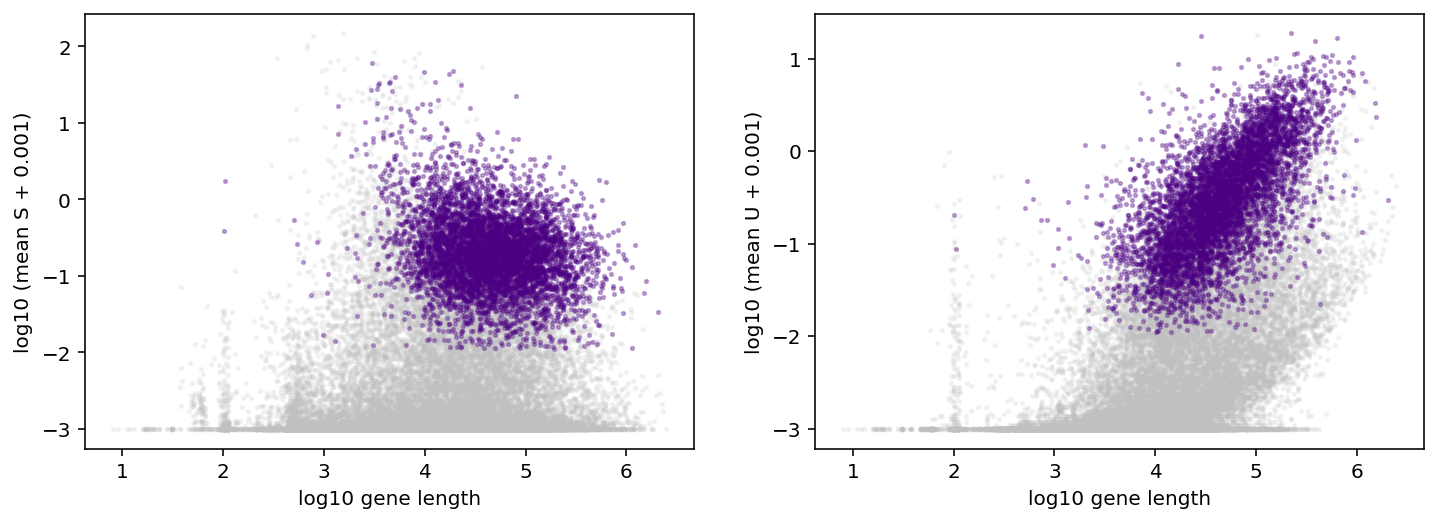

In [68]:
#Get genes.csv
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='pbmc_mek',batch_id=1,\
                                             datestring='230620', n_genes=1000,\
                                             exp_filter_threshold=None,cf=cf) 


In [69]:
dir_string = './fits/gg_230620_025_pbmc_mek_1' 
dataset_strings = [ dir_string+'/'+item for item in dataset_names]
print(dataset_strings)

['./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3', './fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5']


**Overwrite genes.csv with selected gene markers (from above), for inference**

In [70]:
sel_genes = pd.read_csv('./fits/gg_230620_025_pbmc_mek_1/genes.csv',header=None) #fin_markers
sel_genes.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,NIPAL3,PLOD1,TGFBR3,C1orf21,MIIP,SLAMF1,SYF2,DHDDS,TARDBP,FAAH,...,APOOL,PGK1,COX7B,YIPF6,LAS1L,CCDC22,GRIPAP1,GK,SCML1,NHS


In [71]:
first_sel = list(sel_genes.iloc[0])

In [72]:
#remain = list((set(first_sel)^set(fin_markers))&set(first_sel))
for i in range(len(fin_markers)):
    sel_genes[i] = fin_markers[i]
    
    
sel_genes.head()

,0,1,2,3,4,5,6,7,8,9,...,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081
0,IQGAP2,DPYD,CD53,BPGM,BIN1,CDC42,CHST15,EBPL,PLEK,NLRP3,...,TESPA1,CORO2A,SEC62,FKBP5,TIMP2,CSF2RA,CD52,TUT7,RAP1B,UBXN11


In [73]:
sel_genes.to_csv('./fits/gg_230620_025_pbmc_mek_1/genes.csv',header=None,index=None)

In [74]:
#Check that saved genes look ok
test = pd.read_csv('./fits/gg_230620_025_pbmc_mek_1/genes.csv',header=None)
test.head()

,0,1,2,3,4,5,6,7,8,9,...,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081
0,IQGAP2,DPYD,CD53,BPGM,BIN1,CDC42,CHST15,EBPL,PLEK,NLRP3,...,TESPA1,CORO2A,SEC62,FKBP5,TIMP2,CSF2RA,CD52,TUT7,RAP1B,UBXN11


## **Run meK-Means Inference**

In [75]:
dataset_names

['pbmc_10k_v3_Tcells_Monocytes_Bcells_k3',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k5']

In [76]:
#Define bounds for parameters
phys_lb = [-2.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 2.5]

#Technical parameters
samp_lb = [-5.666666666666666, -0.6999999999999997] #Determined from notebook -->
samp_ub = [-5.666666666666666, -0.6999999999999997] 
# gridsize = [5,6]
gridsize = [1,1]

**Run Mixture Model**

For k = 3,5

In [78]:
epochs = 10 

In [79]:
result_strings = []
for i in range(num_ks):  #range(num_ks)
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    full_result_strings = inference_parameters.fit_all_grid_points(30,search_data)
    
    result_strings += [full_result_strings]


INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k3
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230620_025_pbmc_mek_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:38<00:00, 52.96s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:22<00:00, 47.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48215734 0.3517421  0.16610056]
Q Function:  -18619936.16963744

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:28<00:00, 49.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48110785 0.35406555 0.1648266 ]
Q Function:  -18419178.68841783

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:27<00:00, 49.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48042056 0.35446845 0.16511099]
Q Function:  -18430230.552776925

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:30<00:00, 50.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48037347 0.35582622 0.16380032]
Q Function:  -18426776.350786954

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:31<00:00, 50.58s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034459 0.35609972 0.16355569]
Q Function:  -18432570.611348215

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:36<00:00, 52.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034456 0.35614738 0.16350805]
Q Function:  -18433220.85255204

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:40<00:00, 53.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.4803446  0.35699882 0.16265658]
Q Function:  -18426046.891975034

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:55<00:00, 58.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034462 0.35769048 0.16196489]
Q Function:  -18426963.325041726

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:34<00:00, 51.61s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.48034457 0.35815094 0.16150449]
Q Function:  -18425003.3538274

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:35<00:00, 51.72s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.48034458 0.35812753 0.16152789]
Q Function:  -18429949.068267852

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/analysis_figures_0 already exists.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/analysis_figures_1 already exists.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/analysis_figures_2 already exists.
INFO:root:Runtime: 1813.6 seconds.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k5
INFO:root:36601 features o

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.77s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.88s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.32183186 0.10891381 0.34766669 0.0661968  0.15539084]
Q Function:  -18654815.123890303

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.35s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31990179 0.09946908 0.34437707 0.0819316  0.15432045]
Q Function:  -18315771.187922698

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.87s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32623452 0.08105924 0.33769182 0.10092569 0.15408874]
Q Function:  -18311612.38669796

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31959929 0.08904991 0.33074509 0.10693913 0.15366659]
Q Function:  -18292860.872237053

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.33s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32247368 0.08319113 0.32081898 0.12012968 0.15338652]
Q Function:  -18309686.356103588

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:34<00:00, 30.85s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32148285 0.08908208 0.31286843 0.1234129  0.15315375]
Q Function:  -18288178.66231005

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.79s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31958587 0.09888246 0.30579241 0.12252922 0.15321004]
Q Function:  -18279451.02231866

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.17s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31949393 0.10596357 0.29782256 0.12298042 0.15373952]
Q Function:  -18275291.522169117

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.57s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.32021599 0.11631731 0.2877996  0.12158935 0.15407775]
Q Function:  -18261712.26653668

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.55s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31770015 0.14558061 0.27705855 0.10553258 0.1541281 ]
Q Function:  -18222680.65709569

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/analysis_figures_0 created.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/analysis_figures_1 created.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/analysis_figures_2 created.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/analysis_figures_3 created.
INFO:root:Directory ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/analysis_figures_4 created.
INFO:root:Runtime: 1822.3 seconds.


In [82]:
import glob

result_strings2 = []
for i in dataset_strings:
    result_strings2 += [glob.glob(i+'/Bursty_Poisson_1x1/grid_scan_result*.res')]
    

In [83]:
#Read in result files for k=3,10
sr = []
for strings in result_strings2:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]
    
sr

INFO:root:Grid scan results loaded from ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/grid_scan_results_2.res.
INFO:root:Grid scan results loaded from ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/grid_scan_results_1.res.
INFO:root:Grid scan results loaded from ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/grid_scan_results_0.res.
INFO:root:Grid scan results loaded from ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/grid_scan_results_2.res.
INFO:root:Grid scan results loaded from ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/grid_scan_results_1.res.
INFO:root:Grid scan results loaded from ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/grid_scan_results_3.res.
INFO:root:Grid scan results loaded from ./fits/gg_230620_025_pbmc_mek_

[[<monod.mminference.SearchResults at 0x7f12e9b9ddd0>,

In [84]:
#Get original search_data file (with U/S counts)
raws = dataset_strings[0]+'/raw.sd'
sd = monod.analysis.load_search_data(raws)
sd

INFO:root:Search data loaded from ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/raw.sd.


## **Analysis of Results**

In [29]:
def check_at_bounds(phys_params,thr=0.01):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [132]:
np.unique([map_dict[t] for t in new_assigns])


array(['Bcells', 'Monocytes', 'Tcells'], dtype='<U9')

In [133]:
#Plot cluster concordance with true labels and distribution of clusters 

def vis_assign(assign,true=None,true_dict=None,title='',figsize=(18, 5)):
    '''
    Plot distribution of cluster assignments and concordance with true or given labels
    
    assign: np.array of cluster assignments (1..k) for each cell
    true: np.array of user-given cluster assignments (numeric) for each cell, optional
    true_dict: dictionary for converting numeric true values to strings, optional
    title: title string for cluster assignment plot
    figsize: tuple for size of figure
    '''
    
    vis_conf_mat = true is not None
    
    if true is None:
        true = assign.copy()
    
    #----- code to match assignment vectors for square confusion matrix- -----
    true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): 
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1
    #-----   --------
    
    

    #Plot cluster assignments and distribution of sizes of each cluster
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    if true_dict is not None:
        hues = [true_dict[t] for t in true] #[true_dict[t]+' ('+str(t)+') ' for t in true]
    else:
        hues = true.copy()
        
    g= sns.histplot(x=assign,hue=hues,hue_order=list(np.unique(hues)), kde=False,ax=ax[0],
                    palette='tab20',multiple="dodge",shrink=0.6,
                    discrete=True)
    
    
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    

    
    #Plot confusion matrix, between true assignments and fit assignments
    if vis_conf_mat:
        heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),
                              ax=ax[1],linewidths=1, cbar_kws={"shrink": 1},
                             annot_kws={"size":6}) 
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        heatmap.axhline(y=0, color='k',linewidth=2)
        heatmap.axhline(y=val.shape[1], color='k',linewidth=2)
        heatmap.axvline(x=0, color='k',linewidth=2)
        heatmap.axvline(x=val.shape[0], color='k',linewidth=2)

        ax[1].set_ylabel('Original label')
        ax[1].set_xlabel('Assigned label')

    plt.tight_layout()
    plt.show()

    

In [152]:
sr[0][0].aic

array([-1689.69897117])

In [158]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,ks,figsize=(18, 5),s=50):
    '''
    Visualize NLL, KLD, and -AIC over epochs of model inference
    
    results: list of lists of SearchResults objs per k tested (e.g. [[SearchResults]] for k=3 & 5)
    title: title string for leftmost, NLL vs epoch, plot
    ks: list of ks tested (e.g. [3,5])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    '''
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*results[i][0].all_qs.flatten()) #only need one cluster result
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]] #-2*n_cells*clus
        fin_k += [len(results[i])]
        
        
        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

            
        kls += list(np.mean(np.sum(concat_klds[:,:,ks_used],axis=1),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [ ]:
#Plot correlation of inferred means to observed means
def plot_means(sd,results_list,figsize=(18,18)):
    
    true_s = sd.layers[1,:,:] #gene x cell
    true_u = sd.layers[0,:,:]
    
    #For each results_list
    
    mean_s = np.mean(true_s,axis=1)
    mean_u = np.mean(true_u,axis=1)
    print(mean_u.shape)

    mm = results[res_inds[1]].param_estimates[:,:,clus_inds[1]] #genes x params
    
    filt = ~check_at_bounds(mm,thr=0.01)
    
    mm_u = (mm[:,0]+(samp_ub[0]+sd[res_inds[0]].gene_log_lengths))-mm[:,1]
    mm_s = (mm[:,0]+samp_ub[1])-mm[:,2]
    print(mm_s.shape)


    
    #gene_log_lengths, samp_ub[0], samp_ub[1], (samp_ub[0]) + np.log10(g_len)
    
    rho =[]
    p = []   
    
    #Plot param histograms
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    g=sns.scatterplot(x=list(mean_u[filt & (mean_u!=0)]),y=list(10**mm_u[filt & (mean_u!=0)]),hue=list(mean_u[filt & (mean_u!=0)]),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[0])
    #ax[2,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1])
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    rho += [np.corrcoef(list(np.log(mean_u[filt & (mean_u!=0)])),list(np.log(10**mm_u[filt & (mean_u!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_u[filt & (mean_u!=0)]),list(10**mm_u[filt & (mean_u!=0)]))[0]]
    
    ax[0].set_xlabel('Obs '+r'$\mu_U$')
    ax[0].set_ylabel('MM '+r'$\mu_U$')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')

    
    
    g2=sns.scatterplot(x=list(mean_s[filt & (mean_s!=0)]),y=list(10**mm_s[filt & (mean_s!=0)]),hue=list(mean_s[filt & (mean_s!=0)]),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1])
    #ax[2,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1])
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))
    
    rho += [np.corrcoef(list(np.log(mean_s[filt & (mean_s!=0)])),list(np.log(10**mm_s[filt & (mean_s!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_s[filt & (mean_s!=0)]),list(10**mm_s[filt & (mean_s!=0)]))[0]]
    
    ax[1].set_xlabel('Obs '+r'$\mu_S$')
    ax[1].set_ylabel('MM '+r'$\mu_S$')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    
    for i, a in enumerate(ax.flat):

       
        bot,top = a.get_ylim()
        l,r = a.get_xlim()

        newl = np.min([bot,l])
        newr = np.max([top,r])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i]),fontsize=14,transform=a.transAxes)
        a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)

        
    plt.tight_layout()
    plt.show()

    
    

In [136]:
sr[0][0].all_klds.shape

(1, 10, 1082)

**Plot results of meK-Means**

In [128]:
#Cluster assignment distribution

#Assign numerical labels to 'original' cell types, for confusion matrix vis
assign_dict = dict(zip(np.unique(list(all_assigns)),range(len(np.unique(list(all_assigns))))))
new_assigns = [assign_dict[x] for x in all_assigns]

map_dict = dict(zip(list(assign_dict.values()),list(assign_dict.keys())))
map_dict

{0: 'Bcells', 1: 'Monocytes', 2: 'Tcells'}

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


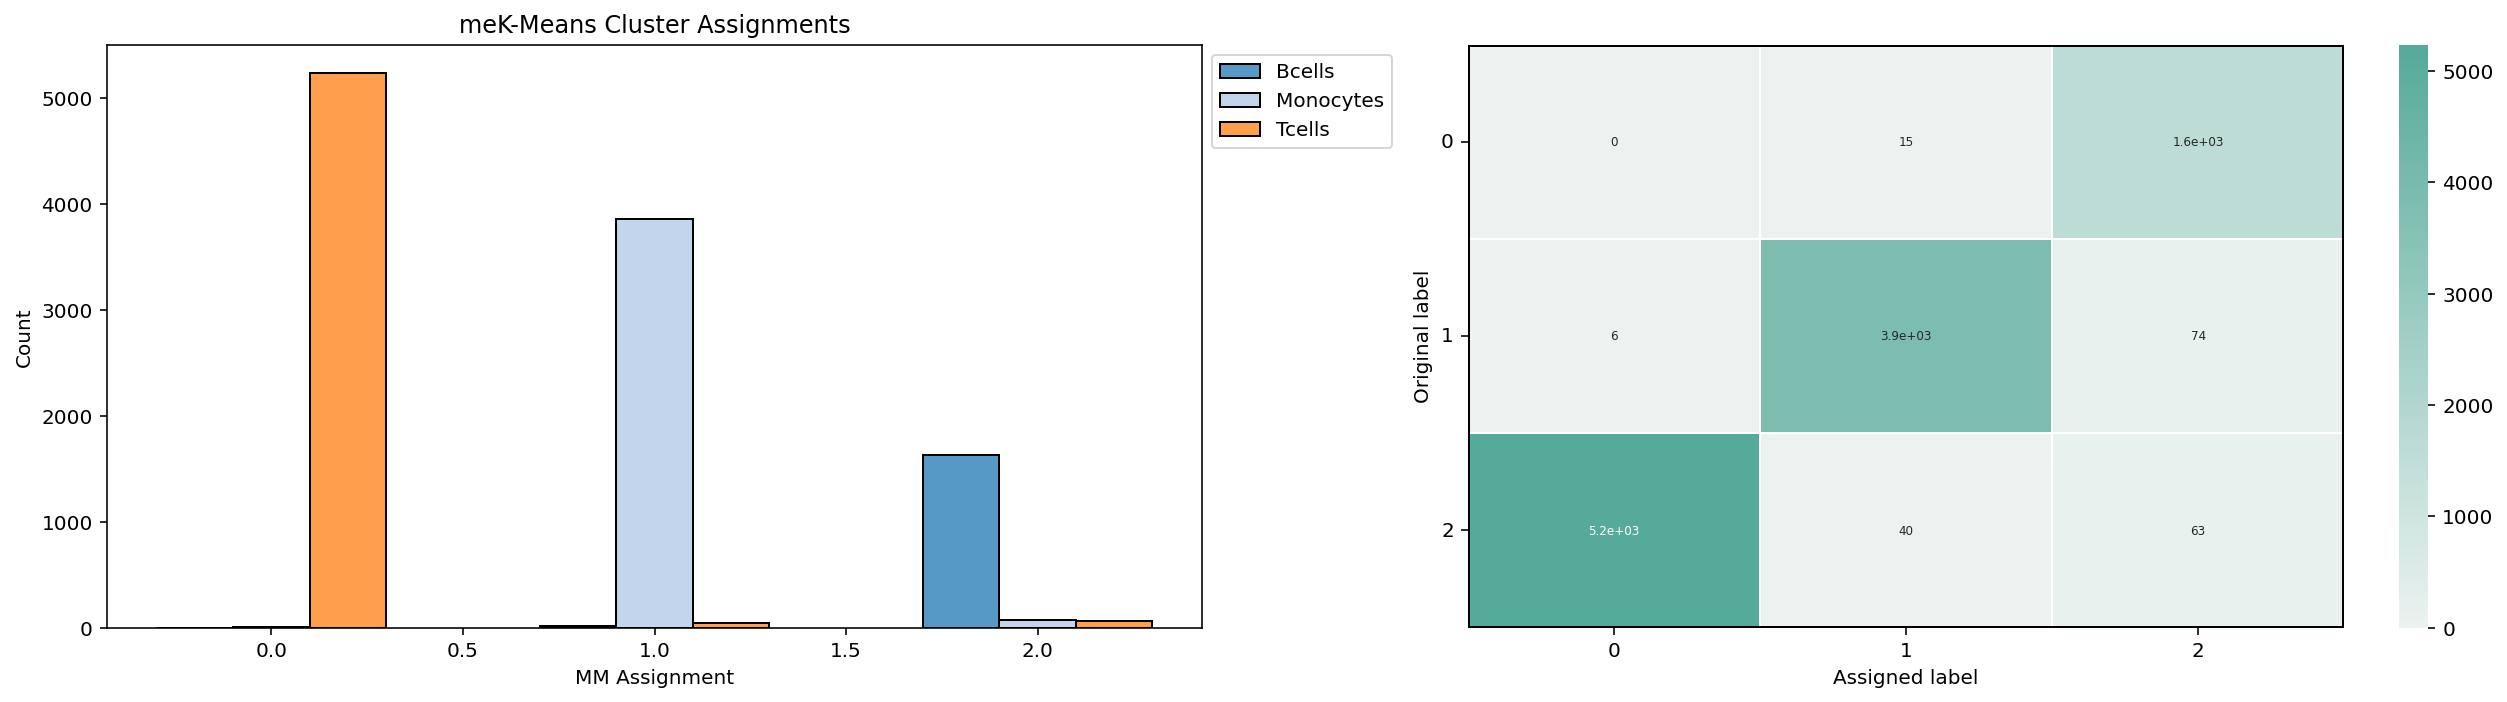

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


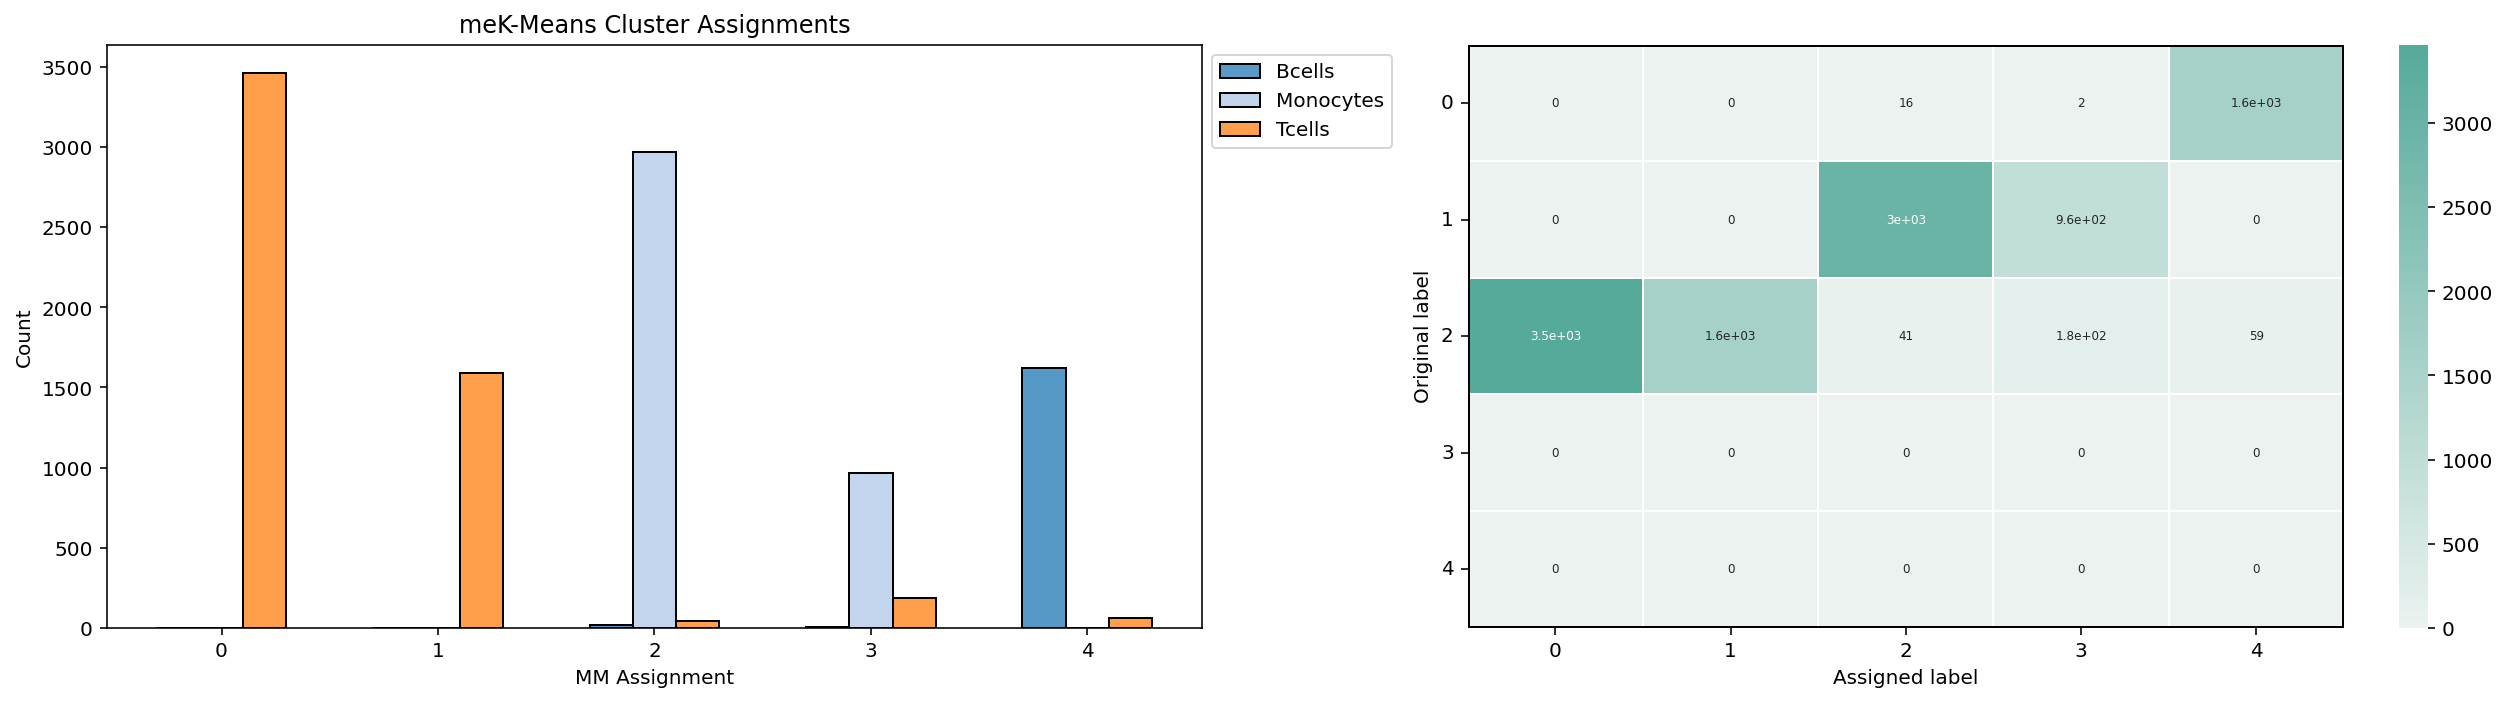

In [134]:
#Concatenate assignments across all cells, from each assigned cluster
mek_assigns = []
for k_res in sr:
    cat_assigns = np.array([None]*len(all_assigns))
    for i in range(len(k_res)):
        r = k_res[i]
        cat_assigns[r.filt] = r.assigns
    
    mek_assigns += [cat_assigns]


for m in mek_assigns:
    vis_assign(m,true=new_assigns,true_dict=map_dict,title='meK-Means Cluster Assignments',figsize=(18, 5))

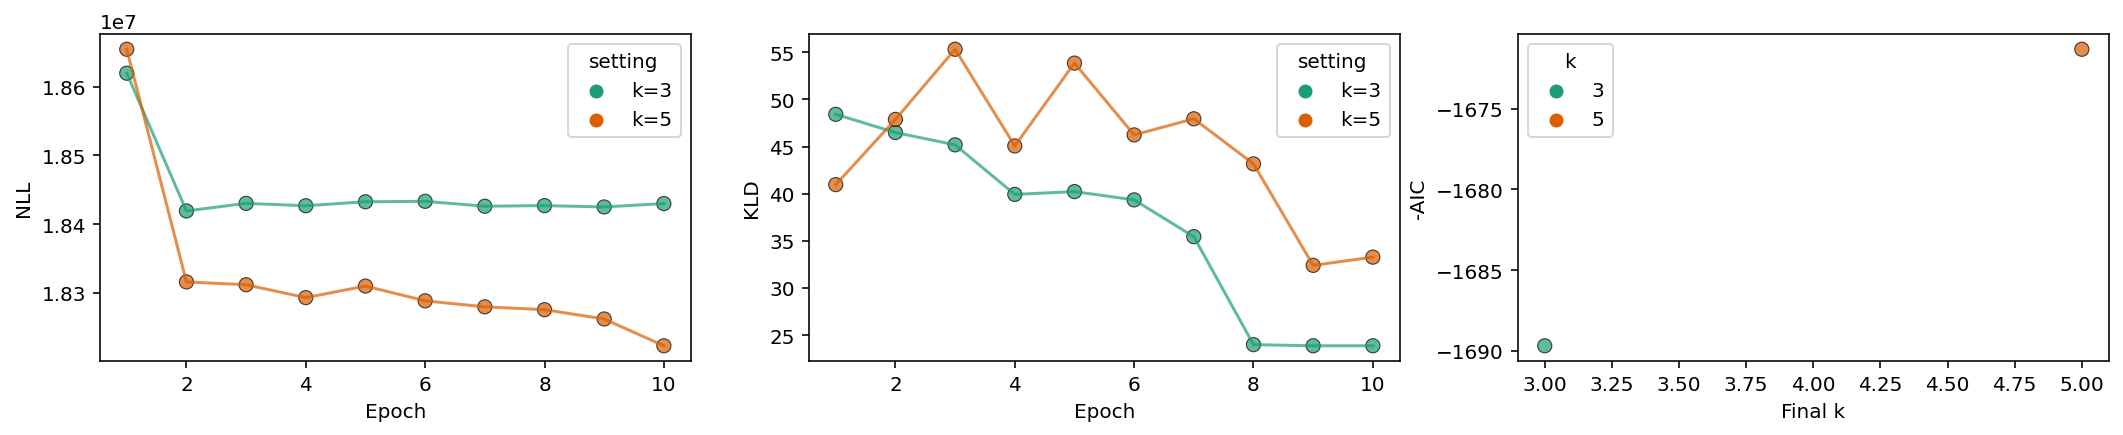

In [166]:
#Metrics from inference runs
vis_metrics(sr,'',[3,5],figsize=(18,3))

In [ ]:
#Correlation of means from params to empirical means, in each k group of cells

Chi-squared testing to reject genes with poor fits

In [41]:
np.sum(r.filt)

1816

In [36]:
sd.layers.shape

(2, 1082, 10913)

INFO:root:Figure stored to ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/analysis_figures_2/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230620_025_pbmc_mek_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/analysis_figures_2/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 92 genes out of 1082. Runtime: 3.4 seconds.
INFO:root:Original optimum: -5.67, -0.70.


IndexError: boolean index did not match indexed array along dimension 2; dimension is 1816 but corresponding boolean dimension is 10913

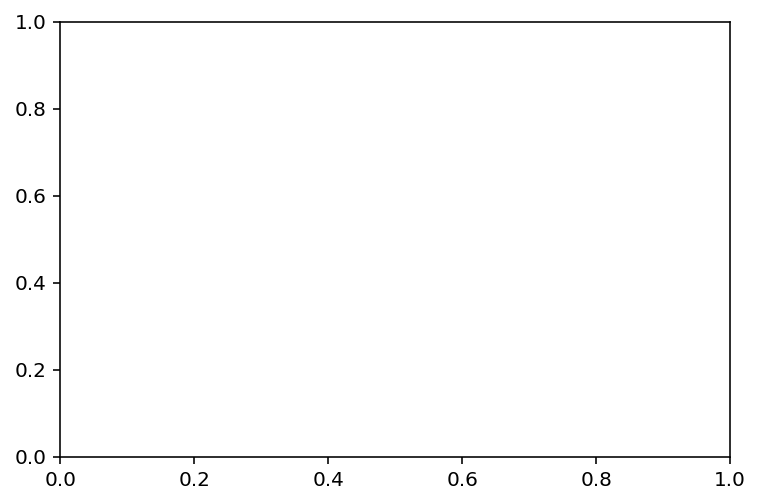

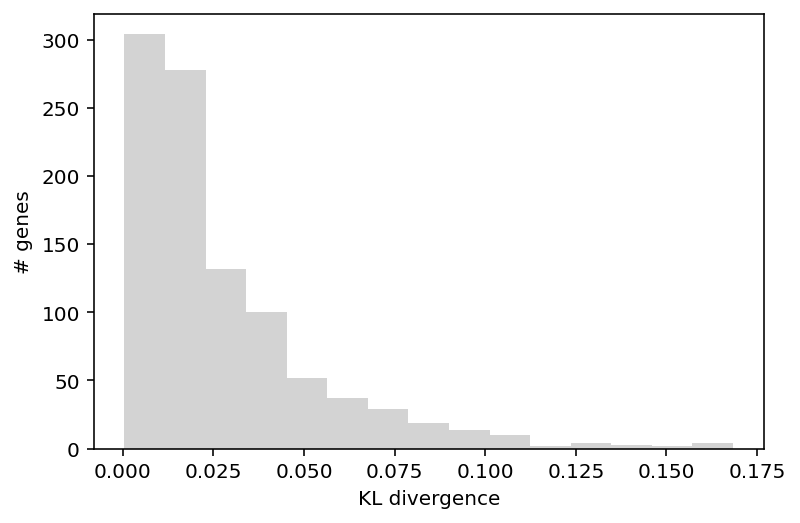

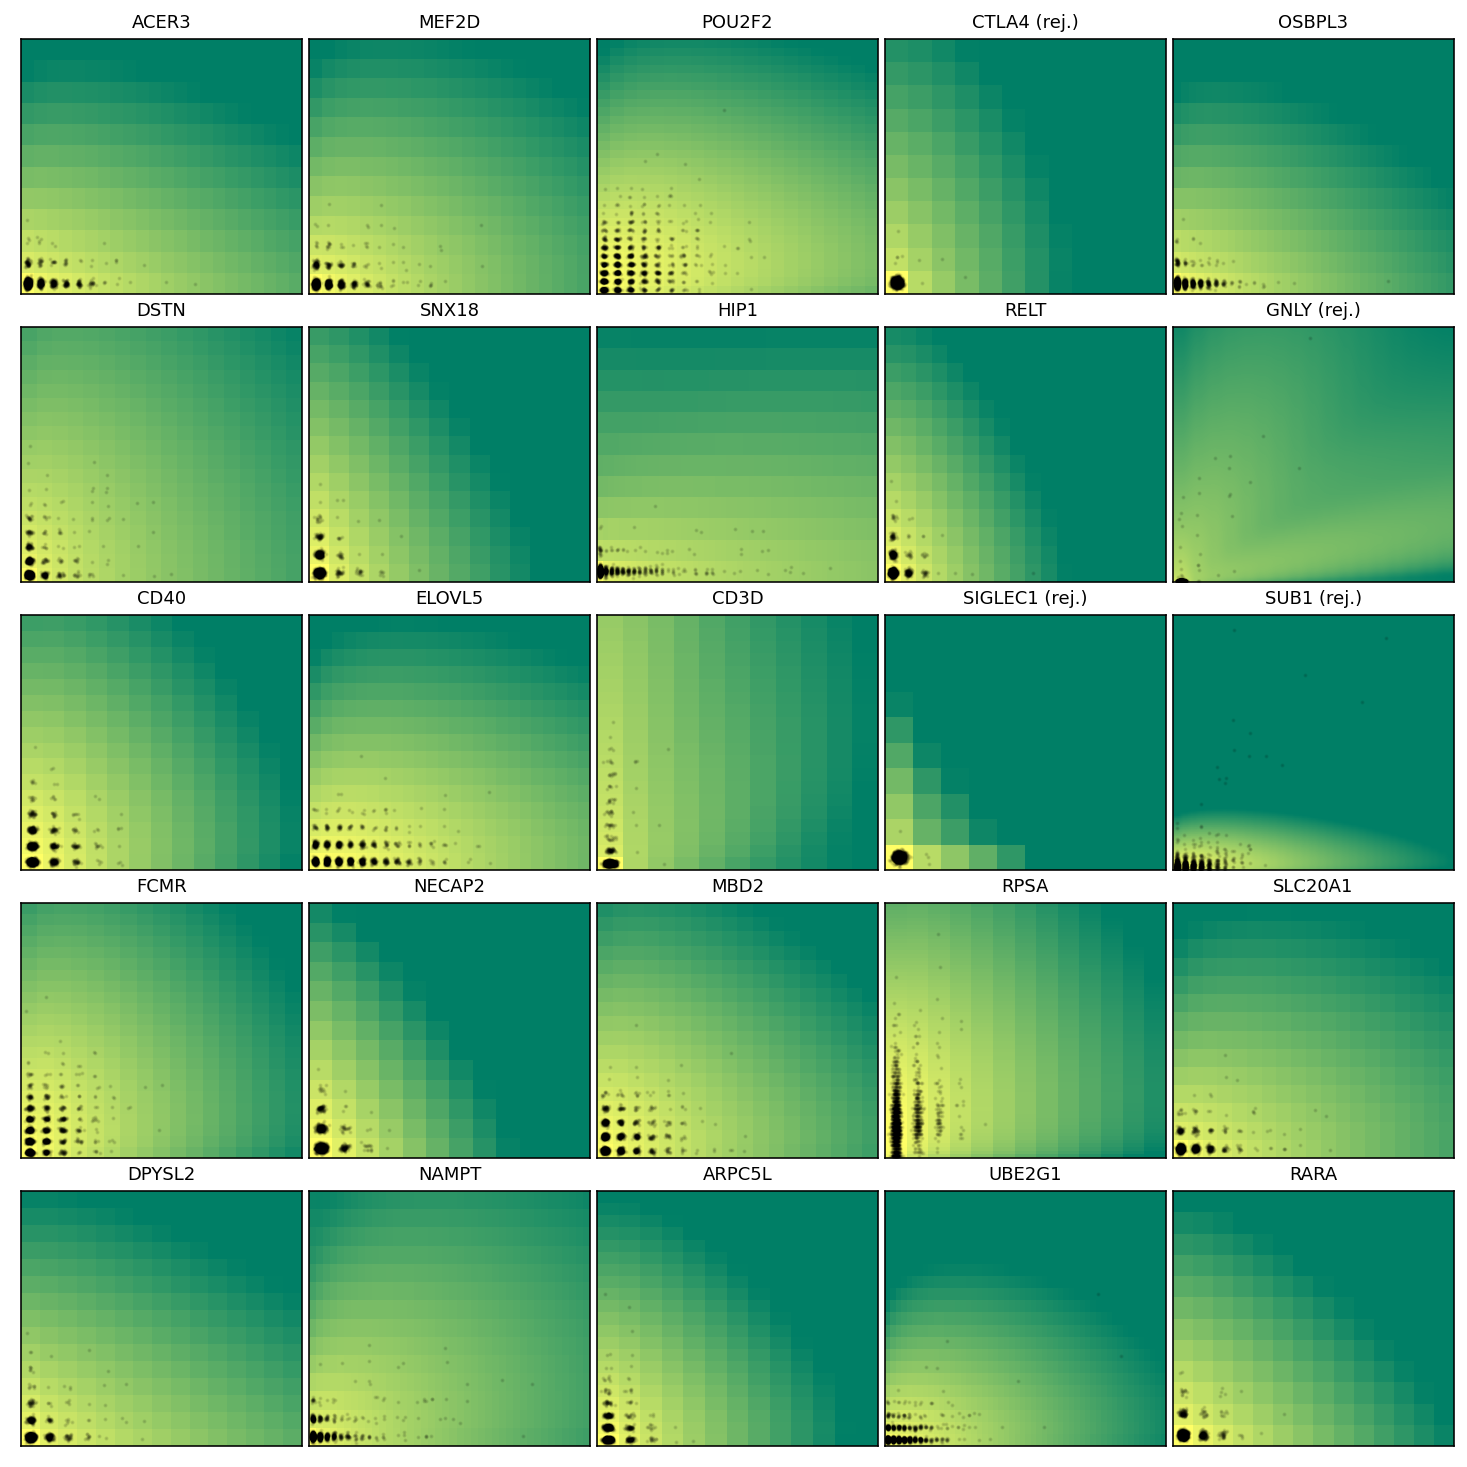

In [35]:
for l in range(len(sr)):
    for r in sr[0]:

        fig1,ax1 = plt.subplots(1,1)
        r.find_sampling_optimum()
        #r.plot_landscape(ax1)

        fig1,ax1 = plt.subplots(1,1)
        r.plot_KL(ax1)

        r.plot_gene_distributions(sd,marg='joint') #Rerun fits, and try uncommenting

        _=r.chisquare_testing(sd,threshold=1e-3)
#         r.resample_opt_viz()
#         r.resample_opt_mc_viz()
        r.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=1e-3) 

        r.compute_sigma(sd,num_cores=60)
        r.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
        r.plot_param_marg()

        monod.analysis.make_batch_analysis_dir([r],dir_string)
        r.update_on_disk()

In [ ]:
result_strings_upd = []
for i in dataset_strings:
    result_strings_upd += [glob.glob(i+'/Bursty_Poisson_1x1/grid_scan_result*_upd.res')]
    
    
sr_arr = []
for strings in result_strings_upd:
    sr_arr += [[monod.analysis.load_search_results(i) for i in strings]]
    
sr_arr

In [ ]:
#Do DE for k=3, Monocytes v B cells and T cells, (one analysis with filt and another w/ filt+rej_filt)



In [ ]:
#Print top DE for each type with scatterplot


In [ ]:
#Add DE plots with error bars


In [ ]:
#Print intersection of DE in both comparison (i.e. strong Monocyte markers)